# 04 Time Series
Author: Murthadza bin Aznam <br>
Date: 6th August 2021<br>

This Notebook is written as part of the International Virtual Conference on Astrostatistics and Machine Learning (IVCASML2021) course.

---

## 0.0 GOAL
The goal of this tutorial is to determine the periodicity of a star given that we have:
1. The time of observation
2. The magnitude at the time observed
3. The time is not necessarily equally spaced

---

## 1 DATA PREPARATION
We use Pandas to read the `.data` file.
- Index '0' is the Julian Date
- Index '1' is the Magnitude difference, $\Delta B$
    - The difference here refers to the difference against a comparison star

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Read data file using pandas
data = pd.read_fwf("../dataset/JD_vs_B.data", header=None)

# Assigning a variable name to the respective data
Date = data[0].to_numpy() # Julian Date
dB = data[1].to_numpy() # Magnitude difference

### 1.0 DATA: Preliminary plotting

Below is a graph of the data that we currently have:
1. Magnitude vs Date

Text(0, 0.5, '$\\Delta B$')

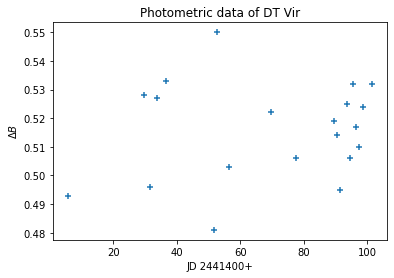

In [3]:
plt.scatter(Date, dB, marker="+")
plt.title("Photometric data of DT Vir")
plt.xlabel("JD 2441400+")
plt.ylabel(r"$\Delta B$")
#plt.xlim(0, 110)
#plt.ylim(0.48, 0.65)

### 1.1 DATA: The difference of the mean magnitude and the respective data points
$$f = \Delta B - \overline{\Delta B}$$

In [4]:
dB_ = np.mean(dB)
f = dB - dB_

### 1.2 DATA: Nyquist Frequency

We use Nyquist frequency to determine a constant spacing between dates in a non-constant spacing of observation date,
$$N_f = \frac{1}{2\times (\Delta \text{Date})_{min}}$$

In [5]:
# Difference between Date
dDate = np.diff(Date)

# Nyquist freq = 1/(2 times minimum difference between day)
N_f = 1/(2*min(dDate))

## 2 Date Compensated Discrete Fourier Transform (DCDFT)

### 2.1 DCDFT: Spectral Correlation Coefficient
The spectral correlation coefficient for a given frequency is given by:

$$S=\frac{c_{i}^{2}+c_{2}^{2}}{\sum_i f_{i}^{2}}$$

WHERE:
$$\begin{aligned}
&c_{1}=a_{1} \sum f_{i} \cos x_{i} \\
&c_{2}=a_{2} \sum f_{i} \sin x_{i}-a_{1} a_{2} c_{1} M\\
&f_i = \text{Difference between the magnitude and the mean magnitude}\\
\end{aligned}$$
and the constants are as follow:
$$\begin{aligned}
&a_{0}^{-2}=N \\
&a_{1}^{-2}=\sum \cos ^{2} x_{i}-a_{0}^{2}\left(\sum \cos x_{i}\right)^{2} \\
&M=\sum \cos x_{i} \sin x_{i}-a_{0}^{2}\left(\sum \sin x_{i}\right)\left(\sum \cos x_{i}\right) \\
&a_{2}^{-2}=\sum \sin ^{2} x_{i}-a_{0}^{2}\left(\sum \sin x_{i}\right)^{2}-a_{1}^{2} M^{2} \\
\end{aligned}$$

In [6]:
def spectral_corr_coef(obs_array, f_array, freq):
    x_array = 2*np.pi*freq*Date
    N = len(x_array)
    cos = np.cos(x_array)
    sin = np.sin(x_array)
    
    #First constant
    a_0 = 1/np.sqrt(N)
    
    #Second constant
    eqn_1 = np.sum(cos**2) - (a_0**2)*(np.sum(cos))**2
    a_1 = 1/np.sqrt(eqn_1)

    #Third constant
    M = np.sum(cos*sin) - (a_0**2)*(np.sum(sin))*(np.sum(cos))
    
    #Fourth constant
    eqn_2 = np.sum(sin**2) - (a_0**2)*(np.sum(sin))**2 - (a_1**2)*M**2
    a_2 = 1/np.sqrt(eqn_2)
    
    # The c_1 and c_2 components
    c_1 = a_1*np.sum(f_array*cos)
    c_2 = a_2*np.sum(f_array*sin) - a_1*a_2*c_1*M
    
    #returns array
    S = (c_1**2 + c_2**2)/np.sum(f_array**2)
    return S

In [7]:
# An array of frequency from 0.1 to N_f
freq = np.linspace(0.1, N_f, num=500)
S = list()

for omega in freq:
    #returns a list
    S.append(spectral_corr_coef(dB, f, omega))

# An array of spectral correlation coefficient at a given frequency
S = np.asarray(S)

Text(0.5, 1.0, 'Spectral correlation coefficient vs frequency')

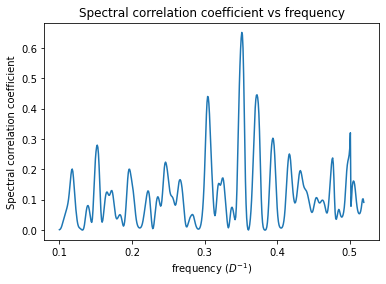

In [8]:
plt.plot(freq, S)
plt.xlabel(r"frequency ($D^{-1}$)")
plt.ylabel("Spectral correlation coefficient")
plt.title("Spectral correlation coefficient vs frequency")

### 2.2 DCDFT: Confidence

We create a function to calculate the confidence of the result:
$$\begin{aligned}
&G=-\frac{N-3}{2} \ln (1-S) \\
&H=\frac{N-4}{N-3}\left(G+e^{-G}-1\right) \\
&\alpha=\frac{2(N-3) \Delta t \cdot \Delta \omega}{3(N-4)} \\
&C=\left(1-e^{-H}\right)^{\alpha}
\end{aligned}$$

We define two functions:
1. H-parameter
2. Confidence (C)

In [9]:
N = len(dB)

def H(S):    
    # G parameter
    frac_g = -(N-3)/2
    ln = np.log(1-S)
    g = frac_g*ln
    
    frac = (N-4)/(N-3)
    bracket = g + np.exp(-g) - 1
    return frac*bracket

def C(S, Date, freq):
    # Alpha parameter
    dT = max(Date) - min(Date)
    dFreq = max(freq) - min(freq)
    numerator = 2*(N-3)*dT*dFreq
    denom = 3*(N-4)
    alpha = numerator/denom
    
    return (1 - np.exp(-H(S)))**alpha

Text(0.5, 1.0, 'H-parameter vs frequency')

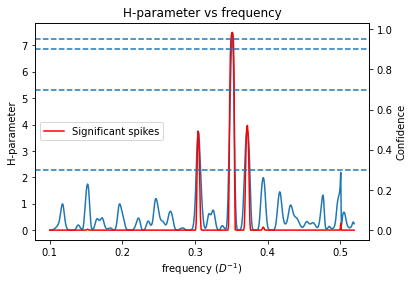

In [10]:
fig, ax = plt.subplots()
ax.plot(freq, H(S), label="H-parameter")
ax.set_ylabel("H-parameter")
ax2 = ax.twinx()
ax2.plot(freq, C(S, Date, freq), color="red", label="Significant spikes")
ax2.legend()
ax2.set_ylabel("Confidence")
ax2.axhline(y=0.3,ls='--')
ax2.axhline(y=0.7,ls='--')
ax2.axhline(y=0.9,ls='--')
ax2.axhline(y=0.95,ls='--')
ax.set_xlabel(r"frequency ($D^{-1}$)")
ax.set_title("H-parameter vs frequency")

### 2.3 DFDCT: Determining the period

We will obtain the period by selecting the frequency with the highest peak:
$$P=\frac{1}{\omega_{highest peak}}$$

In [11]:
# the index of the highest peak
peak_idx = np.argmax(C(S, Date, freq))

# The frequency with the highest peak
peak = freq[peak_idx] 
P = 1/peak # The period
print("Period of this star is: ", P, " Days")

Period of this star is:  2.8474579284190398  Days


### 2.4 DFDCT: Light Curve

Now we plot the respective magnitudes in their respective phases using the Period obtained and we should see a sinusoidal pattern

In [12]:
Phase = (Date - Date[0])/P
Phase = np.mod(Phase, 1)

Text(0.5, 1.0, 'Light curve of the star')

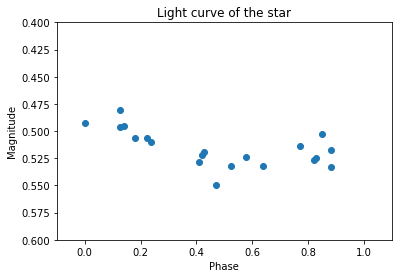

In [13]:
# Light curve
plt.scatter(Phase, dB)
plt.gca().invert_yaxis()
plt.ylim(0.6,0.4)
plt.xlim(-0.1,1.1)
plt.xlabel("Phase")
plt.ylabel("Magnitude")
plt.title("Light curve of the star")